# 4: Decision Trees

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection as sk_ms
import sklearn.tree as sk_tr
import sklearn.metrics as sk_m
import gosdt

In [39]:
df = pd.read_csv('german_credit.csv')

features_df = df.drop(columns=['target'])
feature_names = features_df.columns.to_list()
class_df = df['target']

features_train, features_test, class_train, class_test = sk_ms.train_test_split(features_df, class_df, test_size=0.2, random_state=7)

## (a) Decision Tree Construction

In [40]:
# computes the mean and upper + lower bounds at 0.05 significance level for an array
def mean_lower_upper(data):

    mean = np.mean(data)
    std_dev = np.std(data)
    se = std_dev / np.sqrt(len(data))
    z_score = 1.96 # 0.05 significance
    moe = z_score * se
    lb = mean - moe
    ub = mean + moe

    return mean, lb, ub

depths = range(1,11)

accuracy_means = np.zeros(len(depths))
accuracy_lower_bounds = np.zeros(len(depths))
accuracy_upper_bounds = np.zeros(len(depths))

f1_score_means = np.zeros(len(depths))
f1_score_lower_bounds = np.zeros(len(depths))
f1_score_upper_bounds = np.zeros(len(depths))

auc_means = np.zeros(len(depths))
auc_lower_bounds = np.zeros(len(depths))
auc_upper_bounds = np.zeros(len(depths))

# 5 fold cross validation on depth ranging from 1 to 10
for i, depth in enumerate(depths):

    classifier = sk_tr.DecisionTreeClassifier(max_depth=depth)

    # Get Scores with SciKit Model Selection cross_validate
    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'roc': 'roc_auc'
    }
    scores = sk_ms.cross_validate(classifier, features_train, class_train, cv=5, scoring=scoring)
    
    accuracy_means[i], accuracy_lower_bounds[i], accuracy_upper_bounds[i] = mean_lower_upper(scores['test_accuracy'])
    f1_score_means[i], f1_score_lower_bounds[i], f1_score_upper_bounds[i] = mean_lower_upper(scores['test_f1'])
    auc_means[i], auc_lower_bounds[i], auc_upper_bounds[i] = mean_lower_upper(scores['test_roc'])


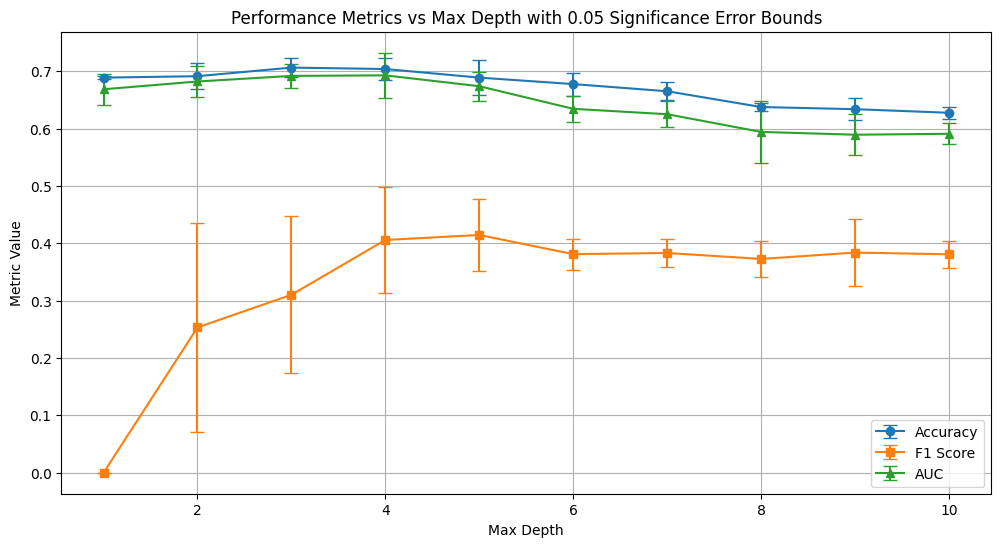

In [41]:
# Plot
plt.figure(figsize=(12, 6))

# Accuracy
plt.errorbar(depths, accuracy_means, yerr=[accuracy_means - accuracy_lower_bounds, accuracy_upper_bounds - accuracy_means], label='Accuracy', fmt='-o', capsize=5)

# F1 Score
plt.errorbar(depths, f1_score_means, yerr=[f1_score_means - f1_score_lower_bounds, f1_score_upper_bounds - f1_score_means], label='F1 Score', fmt='-s', capsize=5)

# AUC
plt.errorbar(depths, auc_means, yerr=[auc_means - auc_lower_bounds, auc_upper_bounds - auc_means], label='AUC', fmt='-^', capsize=5)

plt.xlabel('Max Depth')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Max Depth with 0.05 Significance Error Bounds')
plt.legend()
plt.grid(True)
plt.show()

Metric Choice: As shown below, the proportion of credity-worthy people in the dataset is 0.3. This class imbalance suggests that it is not advisable to use accuracy as a metric. While AUC accounts for different thresholds, it does not account for true and false negatives which are also significant and have different implications within this context. For these reasons, the balanced approach of F1 score (weighing precision and recall), makes it the best metric to evaluate these models. 

In [42]:
# check balance
class_ratio = class_df.sum() / len(class_df)
print(class_ratio)

0.3


Depth Choice: F1 Score peaks at a max depth of 5. Since F1 Score is our preferred metric, a max depth of 5 should yeild the "best" model. 

### Grid Search Cross Validation

In [43]:
# Varrying max_depth, min_samples_split, min_samples_leaf
param_grid = {
    'max_depth': range(1,6),
    'min_samples_split': range(2,6),
    'min_samples_leaf': range(1,6)
}

gs = sk_ms.GridSearchCV(sk_tr.DecisionTreeClassifier(), param_grid, cv=5, scoring='f1')
gs.fit(features_train, class_train)

print(f'Best Parameters: {gs.best_params_}')



Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [44]:
best_classifier  = sk_tr.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=3) # create the classifer with the best parameters from grid search cross validation
best_classifier.fit(features_train, class_train) # train the classifier
class_predictions = best_classifier.predict(features_test) # predict the classes for the test data

accuracy = sk_m.accuracy_score(class_test, class_predictions)
f1 = sk_m.f1_score(class_test, class_predictions)
auc = sk_m.roc_auc_score(class_test, class_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

Accuracy: 0.77
F1 Score: 0.5106382978723404
AUC: 0.6715357283853138


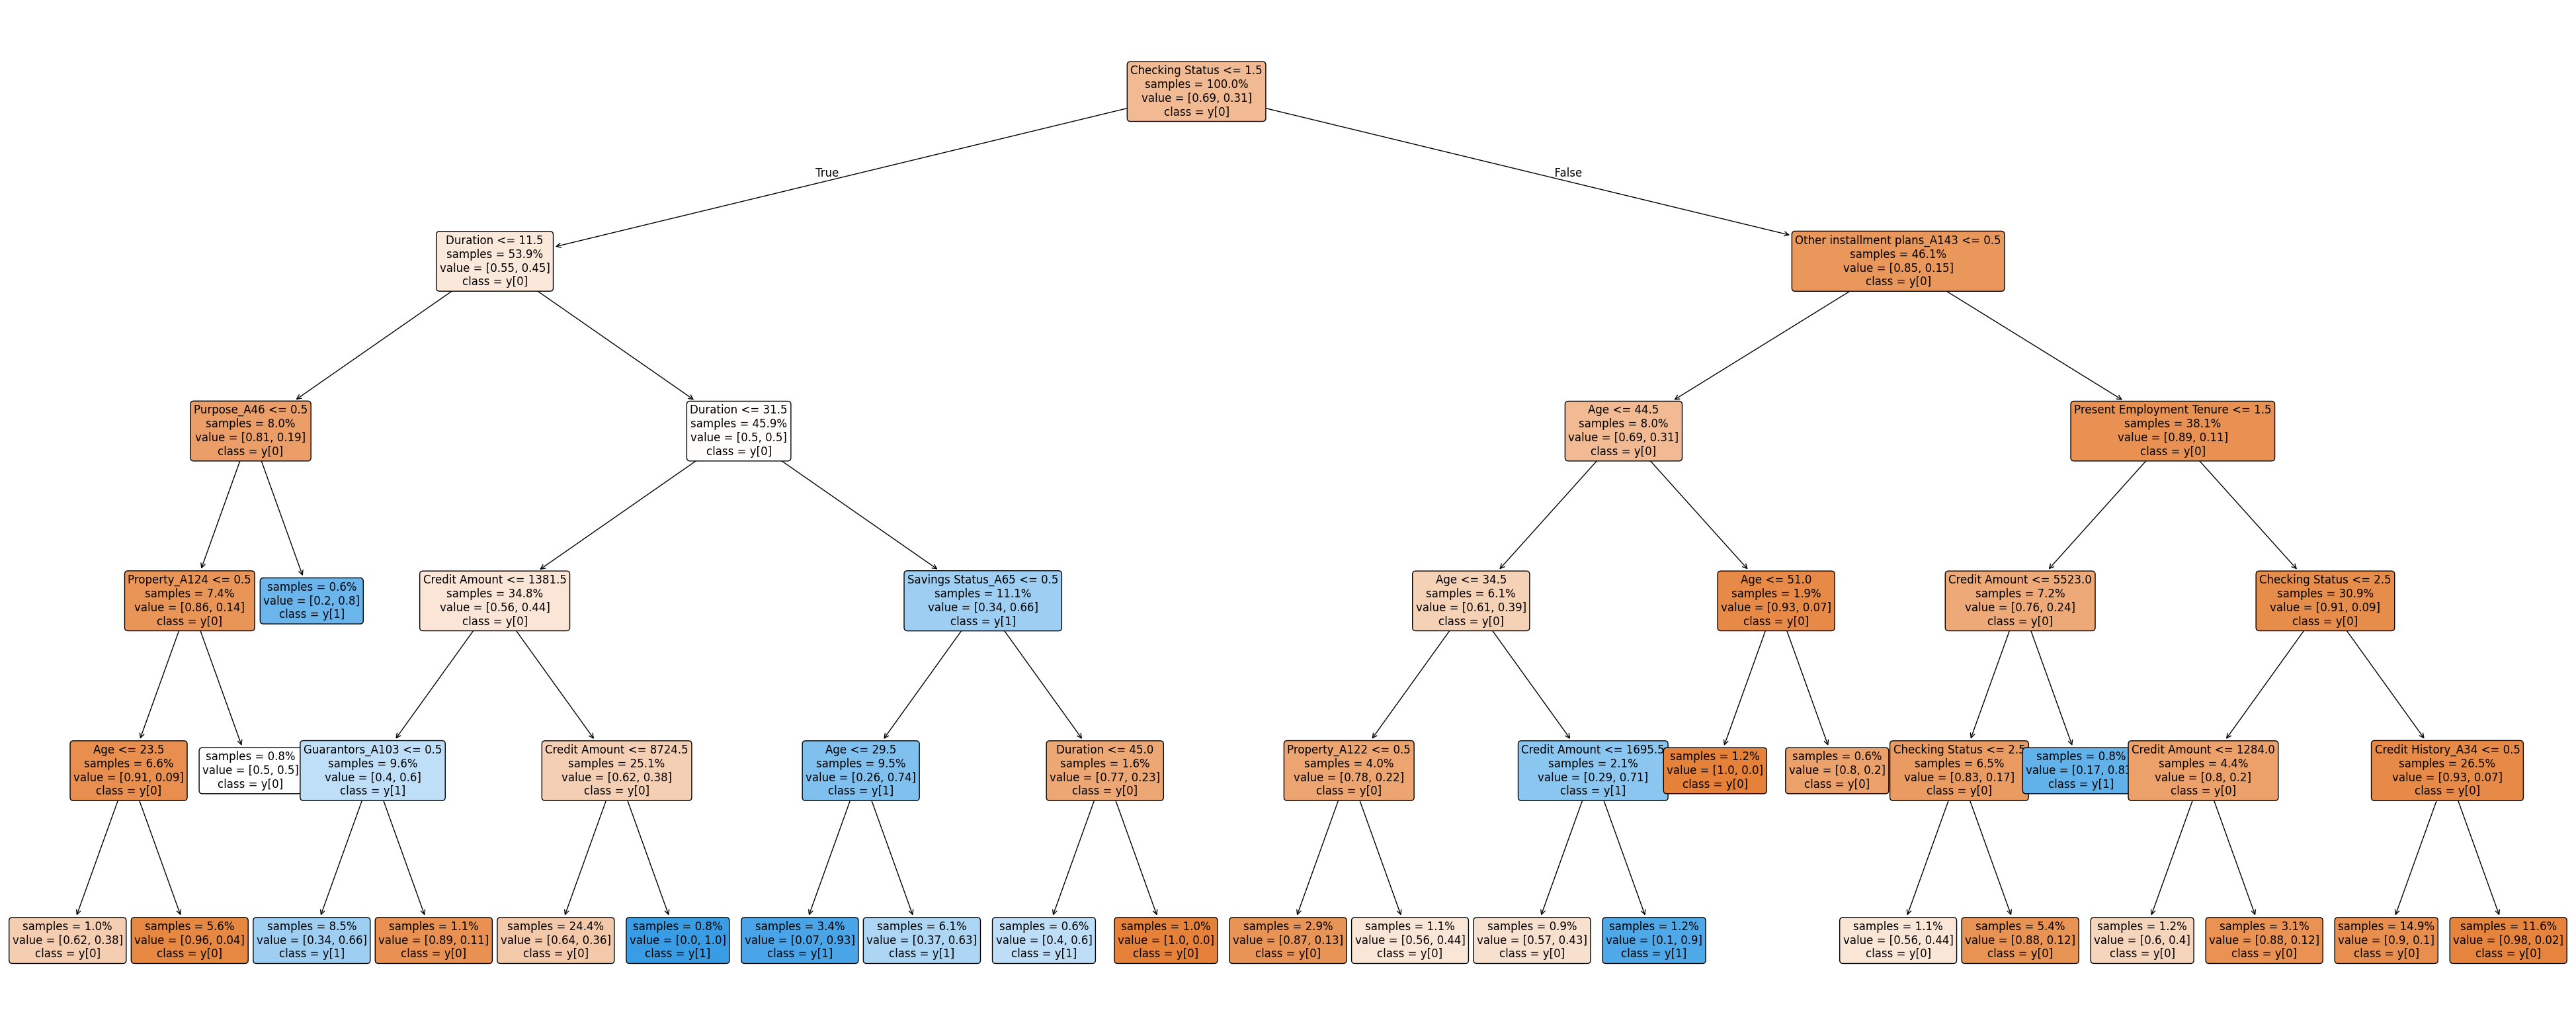

In [49]:
plt.figure(figsize=(50, 20))
sk_tr.plot_tree(best_classifier, filled=True, rounded=True, class_names=True, feature_names=feature_names, fontsize=12, impurity=False, proportion=True, precision=2)
plt.show()

## (c) Sparse Decision Trees: GOSDT

5 Fold Cross Validation to determine the highest performing of 6 regulation values

In [46]:
# Initialize SciKit KFold
kf = sk_ms.KFold(n_splits=5, shuffle=True, random_state=7)
folds = kf.split(features_train)

regularization_vals = [0.01, 0.05, 0.1, 0.2, 0.5, 1]

mean_accuracy_scores = []
mean_f1_scores = []
mean_auc_scores = []

for reg_val in regularization_vals:
     
    configuration = {
        'regularization': reg_val,
        'depth_budget': 3,
        'balance': True
    }
     
    model = gosdt.GOSDT(configuration)

    accuracy_scores = []
    f1_scores =[]
    auc_scores = []

    for train_index, test_index in folds:

        # Split feature and class data into training and test sets for the current fold
        cross_features_train, cross_features_test = features_train.iloc[train_index], features_train.iloc[test_index]
        cross_class_train, cross_class_test = class_train.iloc[train_index], class_train.iloc[test_index]

        model.fit(cross_features_train, cross_class_train)
        predictions = model.predict(cross_features_test)

        # Compute accuracy, f1, auc
        accuracy = sk_m.accuracy_score(cross_class_test, predictions)
        f1 = sk_m.f1_score(cross_class_test, predictions)
        auc = sk_m.roc_auc_score(cross_class_test, predictions)

        # Append scores to the list for the configuration
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        auc_scores.append(auc)
    
    # Append the means for the cross-validation to the lists
    mean_accuracy_scores.append(np.mean(accuracy_scores))
    mean_f1_scores.append(np.mean(f1_scores))
    mean_auc_scores.append(np.mean(auc_scores))


# Find the index of the maximum mean accuracy score
best_accuracy_index = np.argmax(mean_accuracy_scores)
best_accuracy_reg_val = regularization_vals[best_accuracy_index]

# Find the index of the maximum mean F1 score
best_f1_index = np.argmax(mean_f1_scores)
best_f1_reg_val = regularization_vals[best_f1_index]

# Find the index of the maximum mean AUC score
best_auc_index = np.argmax(mean_auc_scores)
best_auc_reg_val = regularization_vals[best_auc_index]

print(f"Best regularization value for accuracy: {best_accuracy_reg_val}")
print(f"Best regularization value for F1 score: {best_f1_reg_val}")
print(f"Best regularization value for AUC: {best_auc_reg_val}")






gosdt reported successful execution
training completed. 0.000/0.000/0.674 (user, system, wall), mem=0 MB
bounds: [0.323631..0.323631] (0.000000) loss=0.293631, iterations=1477
gosdt reported successful execution
training completed. 0.000/0.000/0.591 (user, system, wall), mem=0 MB
bounds: [0.340146..0.340146] (0.000000) loss=0.310146, iterations=1465
gosdt reported successful execution
training completed. 0.000/0.000/0.592 (user, system, wall), mem=0 MB
bounds: [0.337519..0.337519] (0.000000) loss=0.307519, iterations=1485
gosdt reported successful execution
training completed. 0.000/0.000/0.591 (user, system, wall), mem=0 MB
bounds: [0.336520..0.336520] (0.000000) loss=0.306520, iterations=1475
gosdt reported successful execution
training completed. 0.000/0.000/0.575 (user, system, wall), mem=0 MB
bounds: [0.318462..0.318462] (0.000000) loss=0.288462, iterations=1471
Best regularization value for accuracy: 0.05
Best regularization value for F1 score: 0.05
Best regularization value for 

/opt/anaconda3/envs/test_x86-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/test_x86-env/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Retraining on the entire training set using the optimal regularization value of those tested during cross-validation

In [47]:
configuration = {
    'regularization': 0.05,
    'depth_budget': 3,
    'balance': True
}

model = gosdt.GOSDT(configuration)

model.fit(features_train, class_train)
predictions = model.predict(features_test)

# Compute accuracy, f1, auc
accuracy = sk_m.accuracy_score(class_test, predictions)
f1 = sk_m.f1_score(class_test, predictions)
auc = sk_m.roc_auc_score(class_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")



gosdt reported successful execution
training completed. 0.000/0.000/0.877 (user, system, wall), mem=0 MB
bounds: [0.425505..0.425505] (0.000000) loss=0.325505, iterations=1757
Accuracy: 0.645
F1 Score: 0.5644171779141104
AUC: 0.7295038820897486


## (d) Model Comparison

In my implementation, different approaches to constructing decision trees perform better for different metrics. Although my GOSDT implementation is outpuerformed by other decision_tree schemes in accuracy, it performs the best in terms of F1 Score and AUC. Furthermore, since this dataset is unbalanced (see below), accuracy is not an advisable performance metric. Thus, the GOSDT implementation is the best performing model of those tested inside this implementation. 

In [48]:
# check balance
class_ratio = class_df.sum() / len(class_df)
print(class_ratio)

0.3
